In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

### Expectation - Minimization (E-M) algorithm

Consider a scenario where you are given a set of data points coming from two classes / two different gaussian distributions. However, you don't know the class assignments and you would like to predict them. This is a simple case of unsupervised learning and one of the ways by which we can solve this by using K-Means Clustering algorithm.

K-Means hard assigns the class labels i.e. it doesn't tell you the likelihood of a point belonging to two clusters. This can be important especially when the likelihood is near 0.5 for two class case i.e. the model is somewhat equally likely to assign to either of class. Nevertheless, you can try to get the likelihood by running K-Means a number of times with different inital clusters and finding the number of times each point is assigned to different classes. 

Expectation - Minimization (E-M) algorithm is a generative model that tries to model the distribution of various classes in data. It's an example of soft-assignment as it tells you the likelihood of a point belonging to different classes. Assuming that the data is coming from gaussian distributions, it assumes random gaussian priors initially and computes the following two steps:

For each iteration:
1. **E-Step:** Finding probability of each data point belonging to different classes $P(x|C_{i})$ and assigning it to the class where it's maximum
2. **M-Step:** Once all the datapoints are assigned different classes in **E-Step**, updating priors by maximizing likelihood 

In [2]:
def make_distribution(mu, sigma, num_points):
    return np.random.normal(mu, sigma, num_points)

def make_data(mu1, mu2, sigma1, sigma2, num_points):
    X1 = make_distribution(mu1, sigma1, num_points)
    X2 = make_distribution(mu2, sigma2, num_points)
    return X1, X2

We will generate data from two independent gaussian distributions and mix them. The aim of E-M algorithm is to find the true distribution with which the data is generated.

In [3]:
mu1 = 5
mu2 = 45
sigma1 = 5
sigma2 = 15
num_points = 1000

X1, X2 = make_data(mu1, mu2, sigma1, sigma2, num_points)
X = np.hstack((X1, X2))
np.random.shuffle(X)

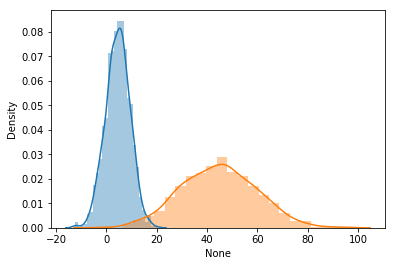

In [4]:
import warnings
warnings.filterwarnings('ignore')

sns.distplot(X1)
sns.distplot(X2)
plt.show()

### Self-correcting mechanism of E-M algorithm

Regardless of whatever initial priors you have, E-M algorithm works in a manner that it self-corrects with every iteration and converges to optimal distributions, as long as the data points are well-separated, otherwise, it may not work well.

We can use uniform priors all the time i.e. not accounting for distribution of class points at every iteration, or we can keep updating the priors through the process.

In [5]:
def get_likelihood(x, mu, sigma):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-np.square((x - mu) / sigma))

def get_probabilities(X, mean_iter1, mean_iter2, sigma_iter1, sigma_iter2):
    # getting likelihoods for different classes
    prob1 = list(map(lambda x: get_likelihood(x, mean_iter1, sigma_iter1), X))
    prob2 = list(map(lambda x: get_likelihood(x, mean_iter2, sigma_iter2), X))

    prob1 = np.array(prob1)
    prob2 = np.array(prob2)

    # normalizing probabilities
    prob1, prob2 = prob1 / (prob1 + prob2), prob2 / (prob1 + prob2)
    return prob1, prob2

def get_class_points(prob1, prob2, prior=None):
    if prior is not None:
        prob1 = prior[0] * prob1
        prob2 = prior[1] * prob2

    labels = (prob2 > prob1) * 1
    X1 = X[labels == 0]
    X2 = X[labels == 1]
    return X1, X2

def get_MLE_estimates(X1, X2):
    mean_iter1 = np.mean(X1)
    sigma_iter1 = np.std(X1)

    mean_iter2 = np.mean(X2)
    sigma_iter2 = np.std(X2)
    return mean_iter1, mean_iter2, sigma_iter1, sigma_iter2

In [6]:
def run_E_M_algorithm(X, mean_iter1, mean_iter2, sigma_iter1, sigma_iter2, num_iters, use_priors=False):
    estimates = []

    # starting with uniform prior 
    prior = np.array([0.5, 0.5])

    for _ in tqdm(range(num_iters)):
        prob1, prob2 = get_probabilities(X, mean_iter1, mean_iter2, sigma_iter1, sigma_iter2)

        # expectation step (E-Step)
        if use_priors:
            X1, X2 = get_class_points(prob1, prob2, prior)
        else:
            X1, X2 = get_class_points(prob1, prob2)
        
        # update priors
        prior = np.array([len(X1) / len(X), 1 - len(X1) / len(X)])

        # maximization step (M-Step)
        mean_iter1, mean_iter2, sigma_iter1, sigma_iter2 = get_MLE_estimates(X1, X2)
        estimates.append([mean_iter1, mean_iter2, sigma_iter1, sigma_iter2])

    estimates = np.array(estimates)    
    return estimates

In [7]:
def plotting(estimates):
    plt.figure(figsize=(20, 5))
    plt.subplot(121)
    plt.plot(estimates[:, 0], label='C1')
    plt.plot(estimates[:, 1], label='C2')
    plt.title('Mean')
    plt.legend()

    plt.subplot(122)
    plt.title('Standard Deviation')
    plt.plot(estimates[:, 2], label='C1')
    plt.plot(estimates[:, 3], label='C2')
    plt.legend()
    plt.show()

100%|██████████| 200/200 [00:03<00:00, 60.85it/s]


Final Mean 1: 4.48
Final Mean 2: 45.08
Final Sigma 1: 4.74
Final Sigma 2: 14.31


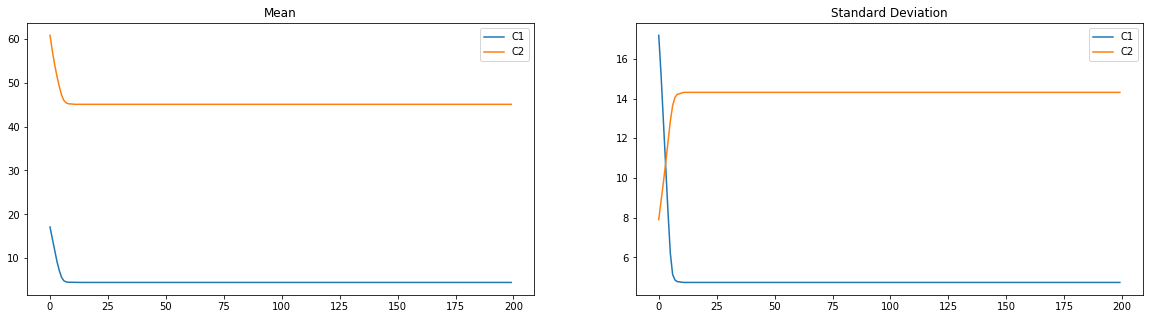

In [8]:
# initial random priors 
mean_iter1 = 1
mean_iter2 = 100
sigma_iter1 = 10
sigma_iter2 = 10

num_iters = 200

estimates = run_E_M_algorithm(X, mean_iter1, mean_iter2, sigma_iter1, sigma_iter2, num_iters, use_priors=False)
mean_iter1, mean_iter2, sigma_iter1, sigma_iter2 = estimates[-1]

print('Final Mean 1:', mean_iter1.round(2))
print('Final Mean 2:', mean_iter2.round(2))
print('Final Sigma 1:', sigma_iter1.round(2))
print('Final Sigma 2:', sigma_iter2.round(2))
plotting(estimates)

We can notice how the E-M algorithm self-corrects and converges around the true distribution parameters